### CSIRO - Image2Biomass Prediction
URL: https://www.kaggle.com/competitions/csiro-biomass/overview

In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/csiro-biomass/sample_submission.csv
/kaggle/input/csiro-biomass/train.csv
/kaggle/input/csiro-biomass/test.csv
/kaggle/input/csiro-biomass/test/ID1001187975.jpg
/kaggle/input/csiro-biomass/train/ID2099464826.jpg
/kaggle/input/csiro-biomass/train/ID2037861084.jpg
/kaggle/input/csiro-biomass/train/ID1211362607.jpg
/kaggle/input/csiro-biomass/train/ID1853508321.jpg
/kaggle/input/csiro-biomass/train/ID193102215.jpg
/kaggle/input/csiro-biomass/train/ID698608346.jpg
/kaggle/input/csiro-biomass/train/ID1859251563.jpg
/kaggle/input/csiro-biomass/train/ID1880764911.jpg
/kaggle/input/csiro-biomass/train/ID853954911.jpg
/kaggle/input/csiro-biomass/train/ID1403107574.jpg
/kaggle/input/csiro-biomass/train/ID1781353117.jpg
/kaggle/input/csiro-biomass/train/ID384648061.jpg
/kaggle/input/csiro-biomass/train/ID1563418511.jpg
/kaggle/input/csiro-biomass/train/ID2125100696.jpg
/kaggle/input/csiro-biomass/train/ID482555369.jpg
/kaggle/input/csiro-biomass/train/ID638711343.jpg
/kaggle/input/c

### Architecture

```mermaid
graph LR
    LoadData --> Preprocess
    Preprocess --> ImageFeatures["Image Features Extraction (CNN)"]
    ImageFeatures --> TabularFeaturePrep["Tabular Feature preparation"]
    TabularFeaturePrep["Tabular Feature preparation"] --> FeatureCombination["Feature combination"]
    FeatureCombination --> LightGBM
    LightGBM --> Inference
```

In [50]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor, log_evaluation
from torchvision import models, transforms
from PIL import Image
from pathlib import Path

print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [51]:
# data import
train_df = pd.read_csv('/kaggle/input/csiro-biomass/train.csv')
test_df = pd.read_csv('/kaggle/input/csiro-biomass/test.csv')
sample_submission = pd.read_csv('/kaggle/input/csiro-biomass/sample_submission.csv')
train_df.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000


In [52]:
# data check
train_df.isnull().sum()

sample_id        0
image_path       0
Sampling_Date    0
State            0
Species          0
Pre_GSHH_NDVI    0
Height_Ave_cm    0
target_name      0
target           0
dtype: int64

In [53]:
clover_g = train_df[train_df['target_name'] == 'Dry_Clover_g']
clover_g.head(6)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
5,ID1012260530__Dry_Clover_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Clover_g,0.0000
10,ID1025234388__Dry_Clover_g,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,Dry_Clover_g,6.0500
15,ID1028611175__Dry_Clover_g,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,Dry_Clover_g,0.0000
20,ID1035947949__Dry_Clover_g,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,Dry_Clover_g,0.4343
25,ID1036339023__Dry_Clover_g,train/ID1036339023.jpg,2015/9/30,Vic,Phalaris_Clover,0.82,7.0000,Dry_Clover_g,23.0755


In [54]:
train_df["Sampling_Date"] = pd.to_datetime(train_df["Sampling_Date"], format="%Y/%m/%d")

train_df["year"] = train_df["Sampling_Date"].dt.year
train_df["month"] = train_df["Sampling_Date"].dt.month
train_df["day"] = train_df["Sampling_Date"].dt.day

train_df[["year", "month", "day"]].head()

,year,month,day
0,2015,9,4
1,2015,9,4
2,2015,9,4
3,2015,9,4
4,2015,9,4


In [55]:
# make seasons
season_list = []
def find_season(month):
    season_month = {
        1:'Summer', 2:'Summer', 3:'Autumn', 4:'Autumn', 5:'Autumn', 6:'Winter', 7:'Winter', 8:'Winter', 9:'Spring', 10:'Spring', 11:'Spring', 12:'Summer'
    }
    return season_month.get(month)

for month in train_df['month']:
    season = find_season(month)
    season_list.append(season)

train_df['Season'] = season_list

In [56]:
train_df.head(5)

,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target,year,month,day,Season
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000,2015,9,4,Spring
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984,2015,9,4,Spring
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751,2015,9,4,Spring
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735,2015,9,4,Spring
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015-09-04,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750,2015,9,4,Spring


In [62]:
feature_cols = [c for c in train_df.columns if c not in ['sample_id', 'image_path','Sampling_Date', 'Sampling_Date', 'State', 'Species', 'target_name', 'year', 'month', 'day', 'Season']]

feature_cols

['Pre_GSHH_NDVI', 'Height_Ave_cm', 'target']

([<matplotlib.patches.Wedge at 0x78f2eababc50>,
 [Text(0.42876443644614376, 1.0129960799721887, 'Spring'),
  Text(-1.0325538274616564, -0.3792526775044368, 'Winter'),
  Text(0.41983374859027495, -1.016729867538393, 'Autumn'),
  Text(1.0291765567474218, -0.3883241108166229, 'Summer')],
 [Text(0.23387151078880566, 0.5525433163484665, '37.3%'),
  Text(-0.5632111786154488, -0.20686509682060186, '36.7%'),
  Text(0.22900022650378632, -0.5545799277482142, '14.6%'),
  Text(0.5613690309531392, -0.21181315135452156, '11.5%')])

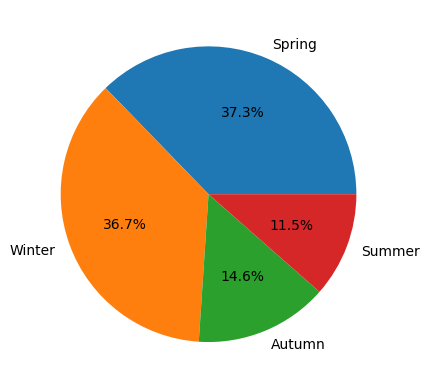

In [70]:
# Season graph
season_counts = train_df['Season'].value_counts()
plt.pie(season_counts, labels=season_counts.index, autopct='%1.1f%%')

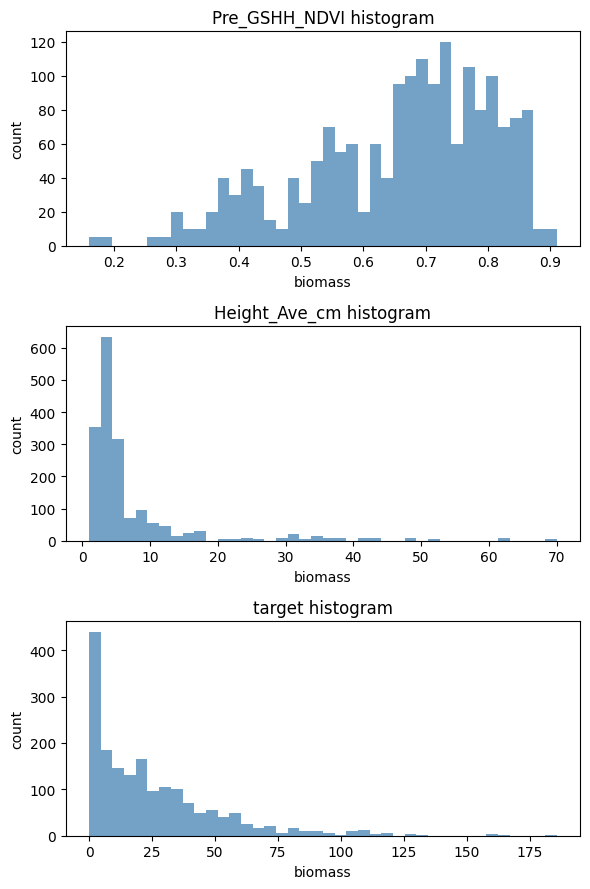

In [63]:
fig, axes = plt.subplots(len(feature_cols), 1, figsize=(6, 3 * len(feature_cols)), sharex=False)

for ax, col in zip(axes, feature_cols):
    train_df[col].plot.hist(ax=ax, bins=40, color="steelblue", alpha=0.75)
    ax.set_title(f"{col} histogram")
    ax.set_xlabel("biomass")
    ax.set_ylabel("count")

plt.tight_layout()

In [ ]:
train_df['sample_id'].dtype

In [ ]:
train_df.describe()

In [ ]:
train_df.head(5)

In [ ]:
tabular_feats = ["Pre_GSHH_NDVI", "Height_Ave_cm", "State", "Species", "year", "month", "day"]

target_col = "target"

# Categorical features
cat_cols = ["State", "Species"]
train_df[cat_cols] = train_df[cat_cols].astype("category")

X = train_df[tabular_feats]
y = train_df[target_col]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.01,
    max_depth=-1,
    num_leaves=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_cols,
    callbacks=[log_evaluation(period=10)],
)

# predict on test set
valid_pred = model.predict(X_val)

In [ ]:
# ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# pretrained model
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
feature_extractor = torch.nn.Sequential(*(list(backbone.children())[:-1])).to(device)
feature_extractor.eval()

def extract_features(img_path: Path) -> torch.Tensor:
    img = Image.open(img_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(x)
    return feat.detach().cpu().flatten()

def add_cnn_features(df, img_root: Path):
    feats = []
    for p in df["image_path"]:
        f = extract_features(img_root / p)
        feats.append(f.numpy())
    feat_df = pd.DataFrame(feats, columns=[f"cnn_{i}" for i in range(f.numel())])
    return pd.concat([df.reset_index(drop=True), feat_df], axis=1)

# Path to train and test images
img_root = Path("/kaggle/input/csiro-biomass")

train_with_feat = add_cnn_features(train_df, img_root)
test_with_feat = add_cnn_features(test_df, img_root)

cnn_feats = [c for c in train_with_feat.columns if c.startswith("cnn_")]
feats = cnn_feats

In [ ]:
feats

In [ ]:
X = train_with_feat[feats]
y = train_with_feat["target"]
model.fit(X, y)

In [ ]:
set(feats) - set(test_with_feat.columns)

In [ ]:
test_pred = model.predict(test_with_feat[feats])

In [ ]:
# Create submission
sub = test_df[["sample_id"]].copy()
sub["target"] = test_pred
sub.to_csv("/kaggle/working/submission.csv", index=False)
print("Done")

In [ ]:
train_df.columns
